<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Bahonar/Bahonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [1]:
!nvidia-smi

Wed Jul 22 16:33:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 778kB 6.5MB/s 
     |████████████████████████████████| 1.1MB 18.7MB/s 
     |████████████████████████████████| 3.0MB 42.2MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'
opensubtitle_file = '/content/drive/My Drive/Thesis/phase-3/opensubtitle.csv'
cornell_file = '/content/drive/My Drive/Thesis/phase-3/cornell.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')
dec_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

In [114]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)

        self.dialogues.history = self.dialogues.history.str.replace(
            "[SEP]", "</s>", n=-1, regex=False) ### SPECIAL CHARACHTER FOR TURN
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        s = self.dialogues['history'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        s = self.dialogues['knowledge'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        s = self.dialogues['response'].apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)

        if(len(result_list)>1000):
          print(len(result_list))

        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [115]:
train_dataset = MyDataset(train_file, max_len=128, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_unseen_dataset))
print(len(test_seen_dataset))

41489
4458
2075
2224


In [116]:
print(enc_tokenizer.decode(train_dataset[2000]['input_pair']))
print(dec_tokenizer.decode(train_dataset[2000]['response']))

<s>Hiking </s> I love hiking, it means to take a vigorous walk in the country side.  </s> I do too. I live near lots of mountains, so it's perfect for me to do too.</s>The term bushwalking is endemic to Australia, having been adopted by the Sydney Bush Walkers club in 1927.</s>
<s>In Australia they call hiking bushwacking!</s>


In [117]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                             shuffle=False, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 6])
****
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 8])
****
2594
279


# Model

In [91]:
from transformers import EncoderDecoderModel, BertTokenizer
from transformers import BartForConditionalGeneration

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
    #     'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-6_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

    self.seq2seq = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

  def forward(self, encoder_input, segments_tensors, decoder_input, **kwargs):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    #kwargs = {'token_type_ids':segments_tensors}
    #kwargs = {}
    outputs = self.seq2seq(input_ids=encoder_input,
                           decoder_input_ids=decoder_input,
                           use_cache=False, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    model_specific_kwargs = {}
    #model_specific_kwargs['token_type_ids'] = {'token_type_ids':segments_tensors}

    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=0,
                                       eos_token_id=2, ## <s> = 0 </s> = 2
                                       **kwargs, **model_specific_kwargs)

    #### generated = [1, len]
    return generated

In [92]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(8, 40).random_(1,1000).to(dev)
# y = torch.LongTensor(8, 10).random_(1,1000).to(dev)
# print(model(x,x,y).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

139420416


#Optimizer



In [118]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
decoder_optimizer = torch.optim.Adam(model.seq2seq.model.decoder.parameters(), lr=1e-5)

In [119]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)
decoder_scheduler = get_constant_schedule(decoder_optimizer)

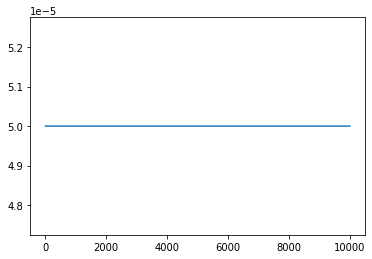

In [ ]:
lrs = []
for i in tqdm(range(10000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [ ]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

Token indices sequence length is longer than the specified maximum sequence length for this model (1037 > 1024). Running this sequence through the model will result in indexing errors


In [120]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [121]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [122]:
from tqdm.auto import tqdm

accumulation_steps = 4

def train_step(batch_idx, batch, step):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  loss = mahdi_loss(model_output, response_batch)
  loss = loss / accumulation_steps
  loss.backward()
  if (step+1) % accumulation_steps == 0:
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()


### UNDER CONSTRUCT
def train_decoder_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  batch_size = pair_batch.shape[0]
  response_batch = response_batch.to(dev)
  encoder_outputs = torch.Tensor(batch_size,20,768).fill_(0).to(dev)
  kwargs = {'encoder_outputs' : (encoder_outputs, None, None)}
  model_output = model(None, None, response_batch, **kwargs)
  loss = mahdi_loss(model_output, response_batch)
  decoder_optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.seq2seq.model.decoder.parameters(), 2)
  decoder_optimizer.step()
  decoder_scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':8,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          'top-k':1
          }
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=600, **kwargs):
  hk_pair =  valid_dataset[idx]['input_pair'].to(dev)
  hk_segment = valid_dataset[idx]['input_pair_segments'].to(dev)
  response = valid_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [ ]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Beheshti"
  step = 0
  log_list = []

In [98]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Beheshti/"
checkpoint = torch.load(model_dir+'beheshti_200000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

200000


In [123]:
model_dir = '/content/drive/My Drive/Thesis/phase-3/Models/Bahonar/'

In [ ]:
from tqdm.auto import tqdm

MAX_STEP = 260000
STEP_SAVE = 2500
STEP_CHECK = 500
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch, step_num)
    #decoder_step_loss = train_decoder_step(batch_idx, batch)
    #log = {'step':step_num, 'train_loss':step_loss, 'decoder_loss':decoder_step_loss}
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      #decoder_train_losses = [step['decoder_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      #avg_decoder_train_loss = sum(decoder_train_losses) / len(decoder_train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      #print("decoder train Loss rate: {} at step {}".format(avg_decoder_train_loss, step_num))
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict()
            }, model_dir+'bahonar.model'.format(step_num))
    step_num += 1

200001


temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> work in child care is an equally important and often overlooked!</s><pad>
model says:  <s><s> work in child care is an equally important and often overlooked job</s><pad>
model says:  <s><s> work in child care is an equally important and often overlooked job!</s>
model says:  <s><s> work in child care is an equally important and often overlooked</s><pad><pad>
model says:  <s><s> work in child care is an equally important and often overlooked job.</s>
model says:  <s><s> work in child care is an equa

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development</s><pad>
model says:  <s><s> early child care is an equally important and often overlooked component of child care</s><pad>
model says:  <s><s> early child care is an equally important and often overlooked component of child development.</s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development!</s>
model says:  <s><s> early child care is an equally 

Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 1024). Running this sequence through the model will result in indexing errors


temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development!</s><pad>
model says:  <s><s> early child care is an equally important and often overlooked component of child development.</s><pad>
model says:  <s><s> early child care is an equally important and often overlooked component of child development</s><pad><pad>
model says:  <s><s> early child care is an equally important and often overlooked part of child development!</s><pad>
model says:  <s><s> early child c

Token indices sequence length is longer than the specified maximum sequence length for this model (1115 > 1024). Running this sequence through the model will result in indexing errors


temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development! Do you</s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development!</s><pad><pad>
model says:  <s><s> early child care is an equally important and often overlooked component of child development. Do you</s>
model says:  <s><s> early child care is an equally important and often overlooked component of child development.</s><pad><pad>
model says:  <s><s

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> yes, it is an important and often overlooked component of child development, but it is
model says:  <s><s> yes, it is an important and often overlooked component of child development, so it is
model says:  <s><s> yes, it is an important and often overlooked component of child development! It is an
model says:  <s><s> yes, it is an important and often overlooked component of child development, but it can
model says:  <s><s> yes, it is an important and often overlooked component of child development. 

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important part of child care!</s><pad><pad><pad>
model says:  <s><s> it is an important part of child care.</s><pad><pad><pad>
model says:  <s><s> it is an important part of child care</s><pad><pad><pad><pad>
model says:  <s><s> it was an important part of child care.</s><pad><pad><pad>
model says:  <s><s> it is an important component of child care!</s><pad><pad><pad>
model says:  <s><s> it was an important part of child care!</s><pad><pad><pad>
model says:  <s><s> I started in early child 

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important and often overlooked component of child development</s><pad><pad>
model says:  <s><s> it is an important and often overlooked component of child development.</s><pad>
model says:  <s><s> it is an important and often overlooked component of child development!</s><pad>
model says:  <s><s> it is an important and often overlooked component of child care</s><pad><pad>
model says:  <s><s> it is an important and often overlooked component of child care!</s><pad>
model says:  <s><s> it is

Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 1024). Running this sequence through the model will result in indexing errors


temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important and often overlooked component of child development. I work in child care</s>
model says:  <s><s> it is an important and often overlooked component of child development. Do you work in child</s>
model says:  <s><s> it is an important and often overlooked component of child development! I work in child care</s>
model says:  <s><s> it is an important and often overlooked component of child development. Do you have any children</s>
model says:  <s><s> it is an important and often ove

Token indices sequence length is longer than the specified maximum sequence length for this model (1115 > 1024). Running this sequence through the model will result in indexing errors


temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important and often overlooked component of child development, so it is important to
model says:  <s><s> it is an important and often overlooked component of child development. I work in child care
model says:  <s><s> it is an important and often overlooked component of child development, but it is important to
model says:  <s><s> it is an important and often overlooked component of child development. I work at a day
model says:  <s><s> it is an important and often overlooked component of c

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important and often overlooked component of child development. I work in child care
model says:  <s><s> it is an important and often overlooked component of child development, so it is important to
model says:  <s><s> it is an important and often overlooked component of child development, but it is important to
model says:  <s><s> it is an important and often overlooked component of child development. I work at a day
model says:  <s><s> it is an important and often overlooked component of c

temperature is 1:
pair is:  <s>Child care </s> i work in child care or daycare </s> How fun! What do you like most about working in child care? </s> caring for children! playing with them and just see them grow </s> That sounds like a very rewarding job! How did you get started in that industry?</s>Early child care is an equally important and often overlooked component of child development.</s>
response is:  <s>i love kids! i think early child care is very important </s>
model says:  <s><s> it is an important and often overlooked component of child development</s><pad>
model says:  <s><s> it is an important and often overlooked component of child care</s><pad>
model says:  <s><s> it is an important and often overlooked component of child development.</s>
model says:  <s><s> it is an important component of child care</s><pad><pad><pad><pad>
model says:  <s><s> it is an important and often overlooked component of child development!</s>
model says:  <s><s> it is an important component of 

In [101]:
model.eval()
kwargs = {'num_beams':8,
          'num_return_sequences':8,'temperature':1, 'max_length':300, 'early_stopping':True,
          'no_repeat_ngram_size':7,
          #'min_length':100,
          #'do_sample':True,
          #'top-k':1
          }
valid_inference(idx=3000, **kwargs)

pair is:  <s>Betta</s>Betta is a large genus of small, often colorful, freshwater ray-finned fishes in the gourami family (Osphronemidae).</s>
response is:  <s>Betta is a large genus of small, often colorful, freshwater ray-finned fishes </s>
model says:  <s><s> betta is a large group of small ones</s>
model says:  <s><s> betta is a large group of fish.</s>
model says:  <s><s> betta is a large variety of fish.</s>
model says:  <s><s> betta is a large variety of fishes</s><pad>
model says:  <s><s> betta is a large variety of fish</s><pad>
model says:  <s><s> betta is a large group of fishes.</s>
model says:  <s><s> betta is a large species of fish.</s>
model says:  <s><s> betta is a large variety of fishes.</s>


In [110]:
text = '''
who is best friend? </s>
'''


input_tns = dec_tokenizer.encode(text, return_tensors='pt').squeeze(0).to(dev)


kwargs = {#'num_beams':1,
          'num_return_sequences':8,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          'do_sample':True
          }
dec_tokenizer.batch_decode(model.generate(input_tns, input_tns, **kwargs))

['<s>eccles, you forgot to take this.</s><pad><pad>',
 '<s>i must go to kalina with the woman</s><pad><pad>',
 '<s>santa monica, and the three of you.</s><pad>',
 '<s>this is her boyfriend, mike j. hank.</s>',
 '<s>in my house i have the best boyfriend</s><pad><pad><pad><pad>',
 "<s>how the hell long she' s been gone?</s><pad><pad>",
 '<s>at a party for old friends and brothers?</s><pad><pad><pad>',
 "<s>i' m so glad to see you, baby.</s><pad>"]

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()
f_scores = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {'num_beams':1,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  idx = 100
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if i % 100 == 0:
    print(sum(f_scores) / len(f_scores))

print( sum(f_scores) / len(f_scores))

0.4
0.372435733294425
0.40606476007038306
0.4110106922978532
0.4070826770783899
0.4130639273945009
0.4086543812150202
0.4089187640673805
0.41192917072043245
0.4120480843937803
0.41089300112475113
0.4102767251513121
0.4114039902309281
0.41366092901487755
0.41254429236492646


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)
from nltk.translate.bleu_score import sentence_bleu

model.eval()
bleus = []
for i in tqdm(range(len(test_unseen_dataset))):
  kwargs = {'num_beams':10,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  idx = 100
  hk_pair =  test_unseen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_unseen_dataset[i]['input_pair_segments'].to(dev)
  response = test_unseen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  bleu = sentence_bleu([response], generateds,weights=(0.25, 0.25, 0.25, 0.25))
  bleus.append(bleu)
  if i%100 == 0:
    print( sum(bleus) / len(bleus))

print( sum(bleus) / len(bleus))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.5623413251903491
0.5298123286439488
0.47594969954812333
0.43807145548061666
0.40842677057790155
0.38469455216463655
0.3638016732935127
0.3448276615670687
0.3283755259226166
0.31320767765169766
0.29923337023230623
0.28636405556534106
0.2742542879460828
0.26304637998976205
0.25226153321908057
0.24199565088854522


KeyboardInterrupt: ignored